# FaceNet - Face Recognition

## Overview
Face recognition problems commonly fall into one of two categories: 

* **Face Verification** "Is this the claimed person?" This is a 1:1 matching problem.

* **Face Recognition** "Who is this person?". This is a 1:K matching problem.

**FaceNet** learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, we can then determine if two pictures are of the same person.


## Encoding Face Images into a 128-dimensional vector

<img src="images/f_x.png" style="width:380px;height:200px;">

We'll use a pre-trained model - [FaceNet](https://arxiv.org/abs/1503.03832)
- This network uses 160x160 dimensional RGB images as its input (a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$)
- The input images are originally of shape 96x96, thus, we need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector.

In [1]:
# Environment 'coursera'
import tensorflow as tf
!python --version
print('\n', tf.__version__)

Python 3.7.6

 2.3.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import PIL

# %matplotlib inline

## Getting Pre-trained model

In [3]:
json_file = open('pretrainedmodel/keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
FRmodel = model_from_json(loaded_model_json)
FRmodel.load_weights('pretrainedmodel/keras-facenet-h5/model.h5')

print(FRmodel.inputs)
print(FRmodel.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [4]:
FRmodel.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

## 1. Face Verification (1:1 comparison)

<img src="images/distance_kiank.png" style="width:600px;height:200px;">


### Helper functions

In [5]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)        # round to even decimal
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [6]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- name of the person to be verified
        database -- python dictionary mapping names to encodings
        model -- model instance
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity])
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = None
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = None
    
    return dist, door_open

### Database of authorized people

In [7]:
database = {}
database["udit"] = img_to_encoding("data/face_recog/ug1.jpg", FRmodel)
database["danielle"] = img_to_encoding("data/face_recog/danielle.png", FRmodel)
database["younes"] = img_to_encoding("data/face_recog/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("data/face_recog/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("data/face_recog/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("data/face_recog/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("data/face_recog/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("data/face_recog/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("data/face_recog/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("data/face_recog/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("data/face_recog/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("data/face_recog/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("data/face_recog/arnaud.jpg", FRmodel)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<class 'PIL.Image.Image'>


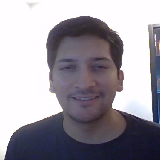

In [8]:
# Loads an image into PIL format.
udit = tf.keras.preprocessing.image.load_img("data/face_recog/ug1.jpg", target_size=(160, 160))

print(type(udit))
display(udit)

In [9]:
database['udit'].round(2)

array([[-0.05, -0.09, -0.07, -0.13,  0.  , -0.02,  0.03,  0.01,  0.06,
        -0.04,  0.14, -0.05, -0.05, -0.12,  0.03,  0.04,  0.06, -0.06,
         0.05, -0.13, -0.11, -0.04, -0.09,  0.1 ,  0.06,  0.07,  0.19,
         0.07, -0.12, -0.02, -0.11,  0.08, -0.06,  0.  ,  0.13,  0.03,
        -0.03,  0.04,  0.17, -0.01,  0.01, -0.03, -0.06, -0.05, -0.15,
        -0.16,  0.07, -0.1 ,  0.02,  0.02,  0.  ,  0.15,  0.19, -0.14,
         0.07,  0.14,  0.04,  0.02, -0.04, -0.06,  0.  , -0.01, -0.04,
         0.17,  0.22,  0.08,  0.04,  0.1 , -0.01,  0.03,  0.06, -0.07,
         0.08, -0.16, -0.02,  0.02, -0.05,  0.06, -0.1 , -0.14, -0.09,
        -0.05, -0.01,  0.11,  0.12, -0.05,  0.1 , -0.08, -0.12,  0.04,
         0.09, -0.05, -0.11, -0.03,  0.07,  0.07, -0.03, -0.05, -0.12,
         0.04,  0.02,  0.15,  0.08, -0.1 ,  0.01,  0.06, -0.02, -0.02,
        -0.  , -0.15,  0.06,  0.1 ,  0.13,  0.05,  0.02,  0.06, -0.05,
         0.2 ,  0.14,  0.16,  0.  , -0.03,  0.12,  0.05,  0.09, -0.13,
      

### Running Verification on New Images

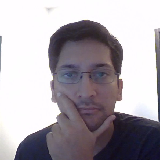

It's udit, welcome in!


(0.541984, None)

In [10]:
img_name = "data/face_recog/ug3.jpg"

test_img = tf.keras.preprocessing.image.load_img(img_name, target_size=(160, 160))
display(test_img)


verify(img_name, "udit", database, FRmodel)

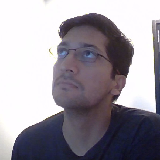

It's udit, welcome in!


(0.5346881, None)

In [11]:
img_name = "data/face_recog/ug4.jpg"

test_img = tf.keras.preprocessing.image.load_img(img_name, target_size=(160, 160))
display(test_img)


verify(img_name, "udit", database, FRmodel)

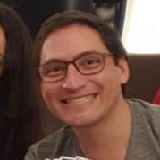

It's not udit, please go away


(1.3618704, None)

In [12]:
img_name = "data/face_recog/martin.jpg"

test_img = tf.keras.preprocessing.image.load_img(img_name, target_size=(160, 160))
display(test_img)


verify(img_name, "udit", database, FRmodel)

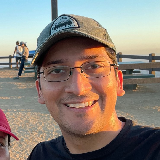

It's not udit, please go away


(1.0533144, None)

In [13]:
img_name = "data/face_recog/ug7.jpg"

test_img = tf.keras.preprocessing.image.load_img(img_name, target_size=(160, 160))
display(test_img)


verify(img_name, "udit", database, FRmodel)

## 2. Face Recognition (1:k comparison)

In [14]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition 1:k comparison
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings of all people
        model -- model instance
    Returns:
        min_dist -- minimum distance between image and encodings from the database
        identity -- name prediction for the person on image_path
    """
    
    encoding =  img_to_encoding(image_path, model)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [15]:
who_is_it("data/face_recog/camera_5.jpg", database, FRmodel)

it's arnaud, the distance is 0.3738901


(0.3738901, 'arnaud')

In [16]:
who_is_it("data/face_recog/martin.jpg", database, FRmodel)

Not in the database.


(1.1525059, 'tian')

## Triplet Loss Function (not used in code)

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

We'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$, and therefore, minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

In [17]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Calculate the triplet loss according to the FaceNet paper
    
    Arguments:
    y_true -- true labels, required for a loss in Keras,. Not needed for this.
    y_pred -- [anchor, positive, negative] each of shape (,128)    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss